<a href="https://colab.research.google.com/github/Gauthameshwar/RAQS_QuantumInspiredAlgos/blob/master/notebooks/GroundStateTensorTrains.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPS + DMRG Ground-State Notebook (Julia/ITensor)
**Notebook author:** Gauthameshwar Sundaravadivel

---

> **Goal**: Build intuition for Matrix Product States (MPS), implement and understand DMRG (ground state search) for a given MPO, then solve a **tilted Ising chain** end-to-end (Hamiltonian, DMRG, diagnostics, plots).  
> **Style**: Hands-on, research-grade. Clear derivations + minimal, readable code with standard Julia library implementations.

---

**Learning Objectives**

- Understand **MPS/TT** as low-entanglement factorizations; connect to **compression/latent-factor models** (e.g., SVD/PCA) in non-quantum data.
- Build the **tilted Ising** Hamiltonian as an **MPO** and translate formulas → code.
- Run **two-site DMRG** robustly; know when/why to use one-site and how to add noise/subspace expansion.
- Read **diagnostics**: discarded weight, energy variance, bond-dimension profile; decide convergence.
- Measure **observables** (local magnetizations at each direction) and **entanglement entropy**; make clean plots.

> **Prerequisites**: Fair introduction to tensor networks, data compression in MPS, basic Julia coding, tensor products in quantum physics, and introduction to quantum spins.

---


## 0. Setup & Notebook Skeleton

- Use Julia ≥ 1.11. Prefer a **project-based** workflow for reproducibility.
- Recommended packages: `ITensors`, `KrylovKit`, `Printf`, `Logging`, `Random`, `LinearAlgebra`.

> **ITensor vs “algorithms”**
>
> In Julia, **ITensors.jl** provides both tensor primitives **and** high-level routines like `dmrg`. We’ll still write thin wrappers so parameters and logging are clean and reproducible.



In [1]:
const USER = "Gauthameshwar"
const REPO = "RAQS_QuantumInspiredAlgos"
const BRANCH = "master"

cd("/content")

if !isdir(REPO)
  run(`git clone --depth 1 -b $BRANCH https://github.com/$USER/$REPO.git`)
end

proj = joinpath("/content", REPO, "env")  # where Project.toml lives

import Pkg
# localpath = "/Users/gauthameshwar/Documents/VSCode/RAQS_QuantumInspiredAlgos" # Use your local path if running this notebook on your local computer
# proj = joinpath(localpath, "env")  # local path
isfile(joinpath(proj, "Project.toml")) || error("Project.toml not found: $proj")


Pkg.activate(proj)
Pkg.instantiate()   # uses Manifest.toml if present; pins exact versions

  Activating project at `/content/RAQS_QuantumInspiredAlgos/env`


> **Tip**
>
> For reproducibility, use the provided enfironment and set a seed: `Random.seed!(1234)` to get consistent results during the sweeps.


In [2]:
using Random, LinearAlgebra, ITensors, ITensorMPS # For constructing and using the MPS algos
using Plots, Printf, Logging, LaTeXStrings # For plotting, formatting the print statements, and logging

Random.seed!(1234)

TaskLocalRNG()

## 1. MPS: Concept → Canonical Forms → Cost

### 1.1 Why MPS?
- **Exponential wall** — a generic state $|\psi\rangle$ on $N$ qubits needs $2^N$ amplitudes in its dense form.
- **Area-law intuition** — many **1D ground states** have short-range entanglement; a **Matrix Product State (MPS)** factors $|\psi\rangle$ into local tensors with bond dimension $\chi \ll 2^{N/2}$.
- **Schmidt/SVD picture** — cut at bond $(\ell\,|\,\ell+1)$ and write
$$
|\psi\rangle = \sum_{\alpha=1}^{\chi^*} \lambda_\alpha\, |\alpha_L\rangle \otimes |\alpha_R\rangle,
$$
keeping only the largest $\chi$ singular values $\{\lambda_\alpha\}$ to form a rank-$\chi$ approximation, thus compressing the information significantly.

> **Entanglement & truncation** — with $p_\alpha = \lambda_\alpha^2$, the bipartite entropy is
> $$
> S = -\sum_\alpha p_\alpha \log p_\alpha,
> $$
> and the **discarded weight** $\delta = \sum_{\alpha>\chi} \lambda_\alpha^2$ upper-bounds the 2-norm truncation error. This mirrors **truncated SVD/PCA** denoising.

---


### 1.2 MPS Definition

An **MPS** of length $N$ over local dimension $d$ is written as a contracted chain of **site tensors** $A^{[k]}$ with one physical leg $i_k\in\{1,\dots,d\}$ and two virtual (bond) legs $\alpha_{k-1},\alpha_k$:

$$
C_{i_1\cdots i_N}
\;=\;
\sum_{\alpha_1,\dots,\alpha_{N-1}}
A^{[1]}_{1\,i_1\,\alpha_1}\,
A^{[2]}_{\alpha_1\,i_2\,\alpha_2}\,
\cdots\,
A^{[N]}_{\alpha_{N-1}\,i_N\,1}.
$$
Open boundaries are encoded by $\chi_0=\chi_N=1$. Equivalently, grouping the $d$ physical slices $A^{[k]\,i_k}$ as $\chi_{k-1}\times\chi_k$ matrices gives the shorthand
$$
|\psi\rangle \;=\; \sum_{i_1,\ldots,i_N} \big(A^{[1]\,i_1} A^{[2]\,i_2}\cdots A^{[N]\,i_N}\big)\,|i_1\cdots i_N\rangle.
$$
The **bond dimensions** $(\chi_0,\ldots,\chi_N)$ control expressiveness; the key complexity knob is $\chi=\max_k \chi_k$.


In [3]:
N  = 6
χ0 = 10

# Build site indices (Qubit convention so X,Z have eigenvalues ±1)
s  = siteinds("Qubit", N)

# Small random MPS; ITensors.jl returns an MPS object
ψ = randomMPS(s, χ0)
normalize!(ψ)

@printf "Toy MPS: N=%d, initial χ0≈%d\n" N χ0
@printf "MPS Details:\n"
for b in eachindex(ψ)
    @printf "  Site %d: dims=%s\n" b size(ψ[b])
end


Toy MPS: N=6, initial χ0≈10
MPS Details:
  Site 1: dims=(2, 10)
  Site 2: dims=(10, 2, 10)
  Site 3: dims=(10, 2, 8)
  Site 4: dims=(8, 2, 4)
  Site 5: dims=(4, 2, 2)
  Site 6: dims=(2, 2)


### 1.3 Costs & Practical Budgets

- **Two-site updates:** $\mathcal{O}(d\,\chi^3)$ per move (dominant cost is the SVD of a reshaped tensor with bond dimension $\chi$ and local dimension $d$).
- **One-site updates:** $\mathcal{O}(d\,\chi^2)$ but may require noise/subspace expansion to avoid local minima.
- **Memory:** $\mathcal{O}(N\,d\,\chi^2)$.

**Rules of thumb.**
- Start with moderate $\chi$ and a loose `cutoff` (e.g., $10^{-9}\!\ldots\!10^{-11}$), add small **noise** early, then tighten the cutoff and grow $\chi$ as needed.
- Watch the **discarded weight** and **variance**; if they plateau above tolerance, increase $\chi$ or adjust the schedule.
- OC placement reduces contractions against large environments: canonical isometries collapse to identities, improving **conditioning** and **speed**.

**Why you care (algorithmic hook).**  
These costs and OC moves are the inner loop of our **ground-state DMRG** in §4: every sweep solves a local problem, **SVD-splits** it, and uses the Schmidt values to truncate. Understanding §1.3–§1.4 makes the DMRG schedules and diagnostics in §4 immediately transparent.


## 2. MPOs and Local Operators

Matrix Product Operators (MPOs) are the natural partner of MPS. Where an MPS encodes a quantum state, an MPO encodes a linear map acting on such states. In physics the most important example is the Hamiltonian $H$, which defines the energy of a system. Representing $H$ as an MPO allows us to apply it efficiently to an MPS, evaluate expectation values $\langle \psi|H|\psi\rangle$, and run algorithms like DMRG directly in the compressed tensor network language. Outside physics, the same idea appears whenever a structured linear operator is needed: transfer matrices in statistical mechanics, cost functions in optimization, or transition rules in probabilistic models.

An MPO is built as a chain of rank-4 tensors $W^{[i]}$ with one physical “input” leg, one physical “output” leg, and two virtual bonds (left and right) that connect to neighbors. Contracting all the $W^{[i]}$ together reproduces the full operator as a giant matrix, but in compressed form. Just as an MPS truncates entanglement to control complexity, the MPO truncates operator entanglement, keeping only the correlations needed to represent the local structure of $H$.

In ITensors, the simplest way to build Hamiltonians is through an `OpSum`. Each local term, like a two-site interaction $-J Z_i Z_{i+1}$ or a one-site field $-h_x X_i$, is added symbolically to the sum. The library then factors this sum automatically into an MPO. This hides the bookkeeping of how local operator strings are stored in the $W$ tensors and ensures that $H|\psi\rangle$ behaves as expected.

Boundary conditions play an important role. Open boundary conditions (OBC) lead to simpler MPOs with smaller bond dimensions, which is why most DMRG codes—including ours—use OBC by default. Symmetries can also be incorporated by assigning quantum number labels to sites, allowing block-sparse MPOs that run much faster, though we will keep things basic here.

To make things concrete, suppose we want the tilted Ising chain Hamiltonian
$$
H = -J \sum_{i=1}^{N-1} Z_i Z_{i+1}
    - h_x \sum_{i=1}^N X_i
    - h_z \sum_{i=1}^N Z_i \, .
$$
This is precisely the model we will study later. Using an `OpSum`, we can write:

```julia
os = OpSum()
for i in 1:N-1
    os += -J, "Z", i, "Z", i+1
end
for i in 1:N
    os += -hx, "X", i
    os += -hz, "Z", i
end
H = MPO(os, s)
```
The object `H` is now an MPO representation of the Hamiltonian acting on the sites `s`. Once defined, we can evaluate expectation values such as `inner(ψ, H, ψ)` or use `H` as the input to DMRG. The efficiency gain is enormous: instead of handling a $2^N\times 2^N$ dense matrix, the MPO representation grows only linearly with $N$ and with modest bond dimension, making large-$N$ ground state searches practical.

This section sets the stage for the main algorithm. DMRG relies on having $H$ in MPO form so that, when the MPS is swept site by site, the local effective Hamiltonians can be built and solved at reasonable cost. Understanding how $H$ is encoded as an MPO makes the logic of the DMRG update rules transparent.

In [4]:
# System size and couplings
N  = 50
J  = 1.0
hx = 0.6
hz = 0.2

# Site indices (Qubit convention so X,Z have eigenvalues ±1)
s = siteinds("Qubit", N)

# Symbolic construction of H, then convert to an MPO
os = OpSum()
for i in 1:N-1
    os += -J,  "Z", i, "Z", i+1
end
for i in 1:N
    os += -hx, "X", i
    os += -hz, "Z", i
end
H = MPO(os, s)

@show size(H) length(s);


size(H) = (50,)
length(s) = 50


## 3. DMRG: Variational Ground-State Search via Two-Site Optimization

In this section we view the Density Matrix Renormalization Group (DMRG) as solving the variational problem

$$
\min_{|\psi\rangle \in \mathcal{M}_\chi} \; \langle \psi | H | \psi \rangle
\quad \text{subject to} \quad \langle \psi | \psi \rangle = 1
$$

where $\mathcal{M}_\chi$ is the manifold of MPS of maximum bond dimension $\chi$. Introducing a Lagrange multiplier $\lambda$ for the normalization constraint leads one to consider the minimization of

$$
\langle \psi | H | \psi \rangle - \lambda (\langle \psi | \psi \rangle - 1)
$$

DMRG solves this by **sweeping** across the sites of the MPS, repeatedly optimizing *local tensors* (either one or two neighboring sites at a time), while freezing the rest of the MPS. The two-site variant is more robust: it allows bond dimensions to grow and handles truncation explicitly via SVD, whereas a one-site update is cheaper but may get stuck unless supplemented by noise or subspace expansion.

### 3.1 Two-Site DMRG Algorithm

1. Start from an initial MPS $|\psi^{(0)}\rangle$ (e.g. random MPS) in mixed canonical form.  
2. Define a sweep schedule: left-to-right, then right-to-left, over all neighboring site pairs $(i,i+1)$.  
3. At each pair:
   - Form the **effective Hamiltonian** on the two-site block by contracting the left and right environment MPOs with current MPS tensors and $H$.
   - Solve the local eigenproblem to find the lowest energy vector in that two-site space (this is analogous to solving the Lagrange-multiplied minimization restricted to that small subsystem).
   - Reshape the obtained two-site tensor and perform SVD: retain singular values up to cutoff or $\chi_{\max}$ to truncate.
   - Update the MPS tensors on sites $i,i+1$, enforce canonical form around them, and move the OC accordingly.  

4. Iterate these sweeps until convergence: energy change per full sweep, discarded weight per bond, and variance $\langle H^2 \rangle - \langle H \rangle^2$ all stabilize within tolerance.

### 3.2 One-Site vs Two-Site Updates & Diagnostics

One-site updates are cheaper (fewer variational parameters, smaller local problem), but they don’t allow bond dimension growth naturally. They can also suffer from local minima unless augmented by perturbations. Two-site updates avoid these downsides at the cost of higher per-step computational cost (roughly $\mathcal{O}(d \chi^3)$ vs $\mathcal{O}(d \chi^2)$ for one-site, neglecting environment costs).


### 3.3 Convergence & Diagnostics (with `cutoff`, `maxdim`, `noise`)

Key diagnostics during DMRG sweeps include the **energy per sweep**, the **discarded weight** (sum of squared singular values dropped at each truncation), the **Schmidt spectrum/bond-dimension profile**, and the **energy variance** $ \langle H^2\rangle - \langle H\rangle^2 $ which should vanish for a true eigenstate. These quantities are controlled in practice by how you **schedule truncation and exploration**:

- **`cutoff!` (accuracy knob).** Sets the SVD truncation threshold at each split. Singular values with squared weight below the cutoff are discarded. Tighter cutoffs (e.g. $10^{-10}$ to $10^{-12}$) reduce **discarded weight** and lower the **variance**, at the cost of larger bond dimensions and runtime.

- **`maxdim!` (capacity cap).** Enforces an upper bound $\chi_{\max}$ on the bond dimension even if the cutoff would keep more. Use a **growing schedule** (e.g. 40→80→160→…) to let the state refine gradually; if convergence stalls with nonzero discarded weight, raise `maxdim`.

- **`noise!` (escape local minima; primarily one-site).** Adds a small randomized perturbation during local updates to help avoid getting stuck in poor gauges/local minima; decay it over the first few sweeps (e.g. $10^{-6}\!\to\!10^{-7}\!\to\!0$). It is most effective for **one-site DMRG**; for **two-site** it is typically ignored/less critical, since two-site updates already grow bonds and recondition the problem.

**Practical pattern.** Start with a loose cutoff and modest `maxdim` plus small noise for 1–2 sweeps to explore; then **tighten the cutoff** and **raise `maxdim`** while setting noise to zero. Watch that (i) energy decreases and plateaus, (ii) discarded weight drops below tolerance, and (iii) variance approaches machine noise.

### 3.3 Where DMRG’s Strength Lies

Because many physically interesting ground states in 1D obey an area law, the entanglement across most cuts is small. Two-site DMRG with manageable $\chi$ can thus reach very good approximations. Understanding canonical forms (§1) and efficient MPO representations (§2) is essential: they make environment contractions stable and local problems tractable. The Lagrange formulation mirrors precisely what DMRG implements in code.

---



After sweep 1 energy=-63.2773748027291  maxlinkdim=41 maxerr=9.98E-11 time=27.268
After sweep 1 energy=-63.27772671255656  maxlinkdim=4 maxerr=9.94E-11 time=0.168
After sweep 1 energy=-63.27772671324242  maxlinkdim=4 maxerr=6.05E-11 time=0.139
After sweep 1 energy=-63.27772671324242  maxlinkdim=4 maxerr=6.05E-11 time=0.142
After sweep 1 energy=-63.277726713242714  maxlinkdim=4 maxerr=6.05E-11 time=0.158
After sweep 1 energy=-63.277726713242416  maxlinkdim=4 maxerr=6.05E-11 time=0.146
After sweep 1 energy=-63.27772671324241  maxlinkdim=4 maxerr=6.05E-11 time=0.090
After sweep 1 energy=-63.2777267132426  maxlinkdim=4 maxerr=6.05E-11 time=0.094
After sweep 1 energy=-63.277726713242394  maxlinkdim=4 maxerr=6.05E-11 time=0.100
After sweep 1 energy=-63.27772671324249  maxlinkdim=4 maxerr=6.05E-11 time=0.104
 31.179965 seconds (19.99 M allocations: 1.951 GiB, 4.87% gc time, 89.24% compilation time)


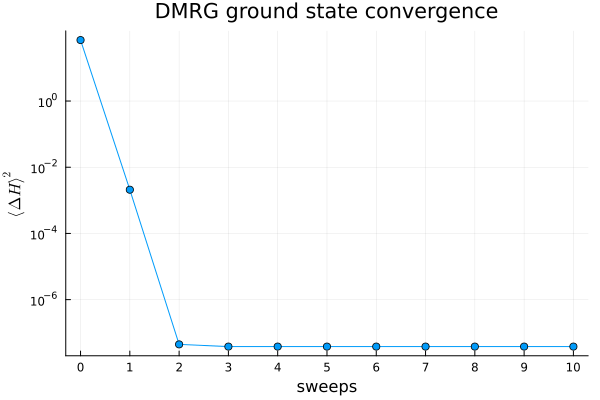

In [5]:
# Initial random MPS
χ0 = 25
ψ = randomMPS(s, χ0)
E = Float64[]
Var_E = Float64[]

# Push the initial energy before the sweeps
push!(E, inner(ψ', H, ψ))
Hψ = H * ψ
push!(Var_E, inner(Hψ, Hψ) - E[end]^2)

@time for s in 1:10
    sweeps = Sweeps(1)
    maxdim!(sweeps, 100)   # set as you like
    cutoff!(sweeps, 1e-10)
    noise!(sweeps, 1e-10)  # helps convergence sometimes
    Eg, ψ = dmrg(H, ψ, sweeps)
    push!(E, Eg)

    # The variance of the energy is a good convergence check
    Hψ = H * ψ
    varE = inner(Hψ, Hψ) - Eg^2
    push!(Var_E, varE)
end

convergence = plot(0:10,
    Var_E,
    marker=:circle,
    xlabel="sweeps",
    ylabel=L"\langle \Delta H \rangle^2",
    xticks=0:10,
    title="DMRG ground state convergence",
    yscale=:log10,
    yticks=[1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10],
    legend=false,
)

display(convergence)


In [6]:
###############  Benchmarking DMRG scaling with N  ###############
using ITensors, BenchmarkTools, Random, Printf, Plots

# ------------------ model & driver helpers ------------------

# Build sites and tilted-Ising MPO (OBC)
function build_tilted_ising(N; J=1.0, hx=0.6, hz=0.2, sitetype="Qubit")
    s = siteinds(sitetype, N)
    os = OpSum()
    for i in 1:N-1
        os += -J, "Z", i, "Z", i+1
    end
    for i in 1:N
        os += -hx, "X", i
        os += -hz, "Z", i
    end
    H = MPO(os, s)
    return s, H
end

# Make a consistent sweeps object of length S
function make_sweeps(S::Int; maxdim_sched=[40,80,160,240,400,600,800], cutoff=1e-10, noise1=1e-6)
    sw = Sweeps(S)
    maxdim!(sw, (i->maxdim_sched[min(i, length(maxdim_sched))]).(1:S)...)
    cutoff!(sw, fill(cutoff, S)...)
    # small noise first sweep (mainly relevant for one-site; harmless for two-site)
    noise!(sw, noise1, fill(0.0, S-1)...)
    return sw
end

# Run DMRG on a *given* MPO H
function run_dmrg(s, H::MPO; χ0=10, S=8, cutoff=1e-10, noise1=1e-6, maxdim_sched=[40,80,160,240,400,600,800])
    ψ0 = randomMPS(s, χ0)
    sweeps = make_sweeps(S; maxdim_sched=maxdim_sched, cutoff=cutoff, noise1=noise1)
    E, ψ = dmrg(H, ψ0, sweeps; outputlevel=0)   # quiet mode (no stdout spam)
    return E, ψ
end

# ------------------ benchmark loop ------------------

function benchmark_scaling(; Ns = [20, 40, 60, 80, 100],
                            J=1.0, hx=0.6, hz=0.2,
                            χ0=10, S=8, cutoff=1e-10, noise1=1e-6,
                            maxdim_sched=[40,80,160,240,400,600,800],
                            seed=1234)

    Random.seed!(seed)

    results = Dict{Int,Dict{Symbol,Float64}}()

    for N in Ns
        @printf("\n--- N = %d ---\n", N)

        # Build once (so we can time dmrg-only)
        s, H = build_tilted_ising(N; J=J, hx=hx, hz=hz)

        # # 1) Total time (build + dmrg) using belapsed (seconds)
        # t_total = @belapsed build_and_dmrg($N; J=$J, hx=$hx, hz=$hz, χ0=$χ0, S=$S,
        #                                    cutoff=$cutoff, noise1=$noise1, maxdim_sched=$maxdim_sched)

        # 2) DMRG-only time reusing the prebuilt MPO
        t_dmrg  = @belapsed run_dmrg($s, $H; χ0=$χ0, S=$S, cutoff=$cutoff, noise1=$noise1,
                                     maxdim_sched=$maxdim_sched)

        # 3) Allocations for DMRG-only
        bytes_dmrg = @ballocated run_dmrg($s, $H; χ0=$χ0, S=$S, cutoff=$cutoff, noise1=$noise1,
                                          maxdim_sched=$maxdim_sched)

        results[N] = Dict(
            # :t_total_sec => t_total,
            :t_dmrg_sec  => t_dmrg,
            :bytes_dmrg  => bytes_dmrg,
            :t_per_sweep => t_dmrg / S
        )

        @printf("Total DMRG: %.3f s | per sweep: %.3f s | alloc: %.2f MB\n",
                t_dmrg, t_dmrg / S, bytes_dmrg/1024^2)
    end

    return results
end

# ------------------ run the benchmarks ------------------

Ns = [20, 40, 60, 80, 100, 150, 200]              # adjust as your budget allows
res = benchmark_scaling(; Ns=Ns, χ0=10, S=8,
                        J=1.0, hx=0.6, hz=0.2,
                        cutoff=1e-10, noise1=1e-6)

# Collect for plotting
t_dmrg  = [res[N][:t_dmrg_sec] for N in Ns]
t_ps    = [res[N][:t_per_sweep] for N in Ns]
mem_mb  = [res[N][:bytes_dmrg]/1024^2 for N in Ns];



--- N = 20 ---
Total DMRG: 0.331 s | per sweep: 0.041 s | alloc: 187.90 MB

--- N = 40 ---
Total DMRG: 0.722 s | per sweep: 0.090 s | alloc: 435.81 MB

--- N = 60 ---
Total DMRG: 1.229 s | per sweep: 0.154 s | alloc: 763.13 MB

--- N = 80 ---
Total DMRG: 1.941 s | per sweep: 0.243 s | alloc: 1102.16 MB

--- N = 100 ---
Total DMRG: 2.495 s | per sweep: 0.312 s | alloc: 1494.16 MB

--- N = 150 ---
Total DMRG: 3.728 s | per sweep: 0.466 s | alloc: 2615.88 MB

--- N = 200 ---
Total DMRG: 5.948 s | per sweep: 0.743 s | alloc: 4022.11 MB


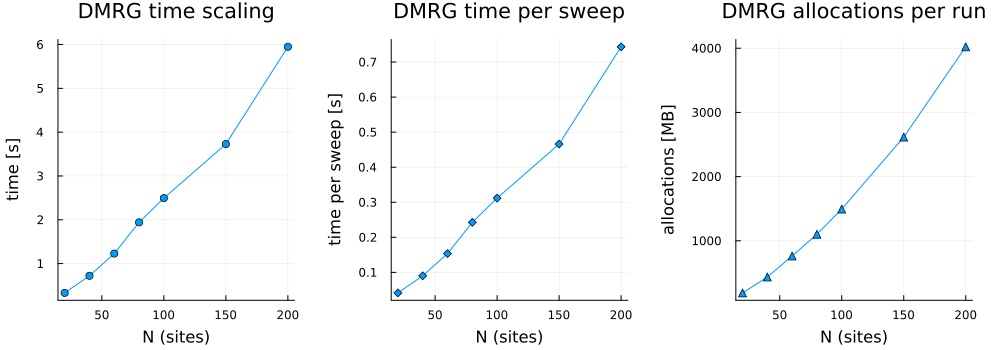

In [7]:
# Plot the benchmark results
using Plots.Measures

# time scaling (log-log is informative)
p1 = plot(Ns, t_dmrg; marker=:circle,
          xlabel="N (sites)", ylabel="time [s]", title="DMRG time scaling", label="")

# per-sweep time (linear axes are fine)
p2 = plot(Ns, t_ps; marker=:diamond,
          xlabel="N (sites)", ylabel="time per sweep [s]", title="DMRG time per sweep", label="")

# memory vs N
p3 = plot(Ns, mem_mb; marker=:utriangle,
          xlabel="N (sites)", ylabel="allocations [MB]", title="DMRG allocations per run", label="")

plot(p1, p2, p3; layout=(1,3), size=(1000, 350), margins=5mm)


## 4. Example Model: Tilted Ising Chain (OBC)

> **A small history on the Ising model**
>
> The classical Ising model is a toy model of spins that have nearest-neighbor coupling. Its Hamiltonian is usually written as
>$$
>H = -J \sum_{\langle i,j \rangle} s_i s_j \; - \; h \sum_i s_i,
>$$
>where $s_i = \pm 1$ are classical spin variables (up or down), $J$ is the coupling constant (positive $J$ favors alignment = ferromagnet, negative $J$ favors anti-alignment = antiferromagnet), the first sum runs over nearest-neighbor pairs $\langle i,j \rangle$, $h$ is an external magnetic field, and the second sum couples each spin to this field.
>It was first proposed by **Wilhelm Lenz (1920)** and studied by **Ernst Ising (1925)** to see if it is possible to have phase transitions in **1D** spin chains. He showed that there is **no** phase transition in 1D systems. Later, this model lept to fame when *Lars Onsager* (1944) showed it is possible to observe phase transitions for **2D** systems with a finite-$T$ transition, launching modern critical phenomena.

Today, the **Ising model** threads through physics, computation, and inference. In the **quantum** chain, classical spins become Pauli operators, and we obtain much richer physics in these systems which makes it a loved model to study all over the physics community. For instance, the quantum Ising chain can undergo a **quantum phase transition**, where the system changes its state not by heating or cooling but purely by tuning a quantum parameter (like a magnetic field). It also exhibits **quantum entanglement**, where distant spins become correlated in ways with no classical counterpart. Even more intriguingly, these models can show **exotic excitations** that behave like particles emerging out of the collective behavior of the spins, providing playgrounds for ideas about quantum computation and new states of matter.

**Classical vs Quantum Ising**

| Feature / Phenomenon | Classical Ising | Quantum Ising |
|----------------------|-----------------|---------------|
| Degrees of freedom   | Binary spins $s_i=\pm1$ | Pauli matrices $X_i, Z_i$ |
| Phase transitions    | 2D (Onsager) finite-$T$ transition | 1D chain has a **quantum critical point** at $h_x/J$ |
| Excitations          | Static domain walls | Quantum domain walls, kinks, avoided crossings |
| Integrability        | Many classical cases integrable | Transverse-field 1D model integrable, but tilt ($h_z$) breaks it |
| Entanglement         | Not defined (probabilistic correlations) | Rich entanglement spectrum, area-law ground states |
| Applications         | Magnetism, statistical mechanics | Quantum criticality, quench dynamics, MPS/DMRG benchmarks |


We will be focusing on the quantum **Transverse-field Ising model** in this notebook.
A transverse field $h_x$ drives quantum fluctuations and a quantum phase transition; a longitudinal **tilt** $h_z$ breaks integrability, introduces domain walls and avoided crossings, and yields non-trivial ground states with modest entanglement—perfect for MPS/DMRG. We choose the Transverse-field Ising model because:
- It is simple to **specify** and **implement** as an MPO.  
- It displays **non-trivial ground states** amenable to MPS with modest bond dimension.  
- It lets us probe **order parameters**, **entanglement scaling**, and **correlation lengths** cleanly.  

$$
H \;=\; -J \sum_{i=1}^{N-1} Z_i Z_{i+1}
       \;-\; h_x \sum_{i=1}^{N} X_i
       \;-\; h_z \sum_{i=1}^{N} Z_i \, .
$$

Here “**tilted**” means simultaneous transverse ($h_x$) and longitudinal ($h_z$) fields. We use `Qubit` sites so that $X,Z$ have eigenvalues $\pm 1$ (no extra $1/2$ factors).

---

**Beyond Physics: Where the Ising Model Matters**

- **Collective phenomena outside physics**. Binary opinions with nearest-neighbor interaction map naturally to Ising couplings. This allows researchers to extend the Ising model to study human interactions in deciding their opinions, social influence, and contagion dynamics. [Lipowski, A., Lipowska, D., & Ferreira, A. L. Phase transition and power-law coarsening in Ising-doped voter model. Phys. Rev. E 73, 032103 (2006).](https://arxiv.org/abs/1706.03575)

- **Biophysics & networks.** On/off activity in gene regulation or neural models, and social influence or contagion dynamics, often admit effective Ising descriptions. [Schneidman et al., *Weak pairwise correlations imply strongly correlated network states in a neural population*, Nature 440, 1007 (2006)](https://www.nature.com/articles/nature04701).

- **Statistical genetics**. The Ising model has turned out to be a universal language for patterns and interactions. It has been used in genetics to detect hidden links between genes in complex diseases.[Majewski, J., Li, H., & Ott, J. The Ising model in physics and statistical genetics. Am. J. Hum. Genet. 69, 853–862 (2001).](https://pubmed.ncbi.nlm.nih.gov/11517425/)

- **Image denoising & segmentation (MRFs)**. These problems can be written as Ising-type energies, where smoothness terms are spin couplings and data terms are local fields; finding the best segmentation is equivalent to finding the Ising ground state. [Boykov, Veksler, Zabih, *Fast Approximate Energy Minimization via Graph Cuts*, IEEE Trans. Pattern Anal. Mach. Intell. 23, 1222 (2001)](https://www.cs.cornell.edu/rdz/Papers/BVZ-iccv99.pdf).

- **Information theory & quantum error correction.** Decoding thresholds of **topological codes** (e.g. toric/surface) map to random-bond Ising models on the Nishimori line, used to estimate maximum tolerable noise for scalable quantum error corrections. [Dennis, Kitaev, Landahl, Preskill, *Topological quantum memory*, J. Math. Phys. 43, 4452 (2002)](https://arxiv.org/abs/quant-ph/0110143).


We now put the MPO to work and run a two-site DMRG ground-state search. We record the energy after each sweep, then extract ground-state observables: site magnetizations $\langle X_i\rangle,\ \langle Z_i\rangle$, the entanglement-entropy profile, and the energy variance $\langle H^2\rangle-\langle H\rangle^2$ as a convergence sanity check.


sweep  1 | E = -63.276747388432
         | Var(E) = 0.0038593
sweep  2 | E = -63.277726713137
         | Var(E) = 3.90587e-08
sweep  3 | E = -63.277726713242
         | Var(E) = 3.81374e-08
sweep  4 | E = -63.277726713242
         | Var(E) = 3.81642e-08
sweep  5 | E = -63.277726713243
         | Var(E) = 3.81292e-08
sweep  6 | E = -63.277726713242
         | Var(E) = 3.81574e-08
sweep  7 | E = -63.277726713242
         | Var(E) = 3.81742e-08
sweep  8 | E = -63.277726713242
         | Var(E) = 3.81542e-08
sweep  9 | E = -63.277726713242
         | Var(E) = 3.81542e-08
sweep 10 | E = -63.277726713242
         | Var(E) = 3.8141e-08
  2.228850 seconds (3.73 M allocations: 990.146 MiB, 9.34% gc time, 29.17% compilation time)


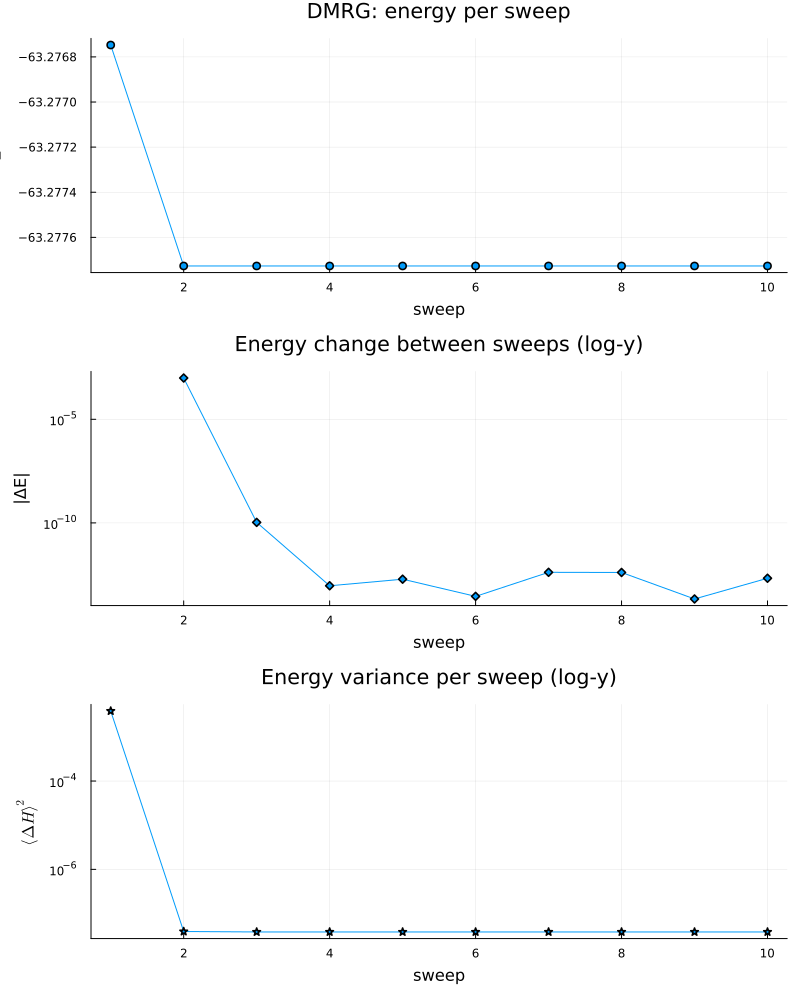

In [8]:
# <H^2> via apply(H, ψ); var(H) = <H^2> - <H>^2
function energy_variance(ψ::MPS, H::MPO; Eg = nothing)
    ϕ = H * ψ
    EH2 = inner(ϕ, ϕ)
    Egv = isnothing(Eg) ? inner(ψ, H, ψ) : Eg
    return EH2 - Egv^2
end

# Return von Neumann entropy across bond b (between sites b and b+1)
# Uses a two-site SVD with NO truncation to extract the singular values.
function bond_entropy(ψ, b)
    # Get the physical index for site b
    sL = siteind(ψ, b)

    # Contract the two MPS tensors across their common link
    Φ = ψ[b] * ψ[b + 1]

    # Perform SVD with no truncation
    U, S, V = svd(Φ, sL; cutoff=0.0)

    # Extract singular values from diagonal ITensor S
    lS, rS = inds(S)

    # Compute singular values
    nsv = min(dim(lS), dim(rS))
    λ = [S[lS=>n, rS=>n] for n in 1:nsv]

    # Normalize probabilities and compute entropy S = -∑ p log p
    p = λ .^ 2
    Z = sum(p)
    if Z == 0
        return 0.0
    end
    p ./= Z
    return -sum(pi -> (pi > 0 ? pi * log(pi) : 0.0), p), length(λ)
end

# ----- Model parameters -----
N  = 50              # number of sites
J  = 1.0
hx = 0.6
hz = 0.2

# ----- Sites and MPO -----
s = siteinds("Qubit", N)

os = OpSum()
for i in 1:N-1
    os += -J,  "Z", i, "Z", i+1
end
for i in 1:N
    os += -hx, "X", i
    os += -hz, "Z", i
end
H = MPO(os, s)

# ----- DMRG: manual per-sweep loop so we can log energies without observers -----
function dmrg_convergence(H::MPO; χ0=10, S=10,
                          maxdim_sched = [40,80,160,240,400,600,800],
                          cutoff = 1e-10, noise_first = 1e-6)
    # s = siteinds(H)
    ψ = randomMPS(s, χ0)
    E = Float64[]
    Var_E = Float64[]

    for sw in 1:S
        sweeps = Sweeps(1)
        maxdim!(sweeps, maxdim_sched[min(sw, end)])
        cutoff!(sweeps, cutoff)
        noise!(sweeps, sw == 1 ? noise_first : 0.0)
        Eg, ψ = dmrg(H, ψ, sweeps; outputlevel=0);
        push!(E, Eg)
        @printf "sweep %2d | E = %.12f\n" sw Eg
        # The variance of the energy is a good convergence check
        varE = energy_variance(ψ, H; Eg=Eg)
        push!(Var_E, abs(varE))
        @printf "         | Var(E) = %.6g\n" varE
    end
    return ψ, E, Var_E
end

@time ψg, E_s, Var_E = dmrg_convergence(H; χ0=10, S=10)

ΔE = [NaN; max.(abs.(diff(E_s)), 1e-14)]

# Basic convergence plots (energy, |ΔE|, and ⟨ΔH⟩^2 on log scale)
p1 = plot(
    1:length(E_s),
    E_s,
    marker=:circle,
    xlabel="sweep",
    ylabel="E",
    title="DMRG: energy per sweep",
    legend=false
)
p2 = plot(
    1:length(ΔE),
    ΔE,
    marker=:diamond,
    yaxis=:log10,
    xlabel="sweep",
    ylabel="|ΔE|",
    title="Energy change between sweeps (log-y)",
    legend=false
)
p3 = plot(
    1:length(Var_E),
    Var_E,
    marker=:star,
    yaxis=:log10,
    xlabel="sweep",
    ylabel=L"\langle \Delta H \rangle^2",
    title="Energy variance per sweep (log-y)",
    legend=false
)
plot(p1, p2, p3, layout=(3,1), size=(800,1000))



Ground-state energy E = -63.277726713242

Ground-state variance var(H) = 3.814e-08


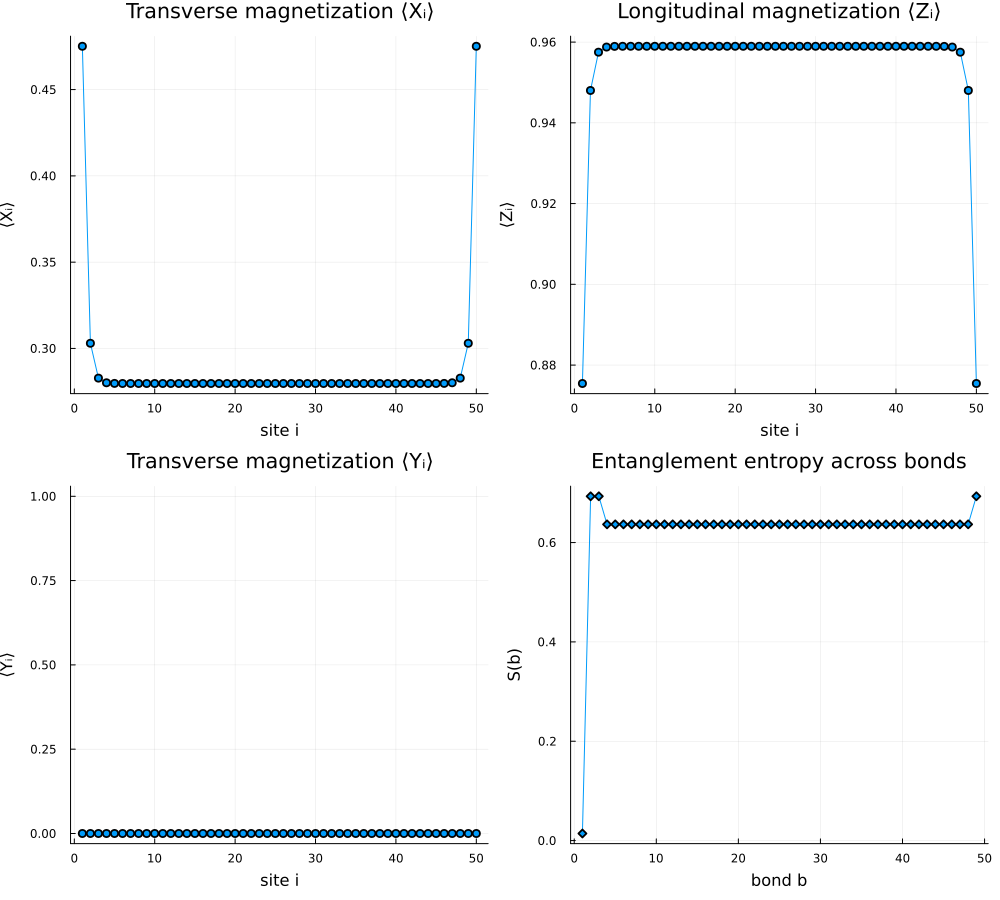

In [9]:
# ⟨O_i⟩ with O ∈ {"X","Y","Z"} (builds a tiny MPO once per site)
function on_site_expect(ψ::MPS, s, opstr::AbstractString)
    N = length(s)
    vals = zeros(Float64, N)
    for i in 1:N
        os = OpSum()
        os += 1.0, opstr, i
        Oi = MPO(os, s)
        vals[i] = real(inner(ψ', Oi, ψ))
    end
    return vals
end

# ----- Compute observables on the ground state ψg -----
mx = on_site_expect(ψg, s, "X")
my = on_site_expect(ψg, s, "Y")
mz = on_site_expect(ψg, s, "Z")

# Entanglement profile and energy variance
Sbond = [bond_entropy(ψg, b)[1] for b in 1:(N-1)]

Eg = E_s[end]
varH = energy_variance(ψg, H; Eg=Eg)
@printf "\nGround-state energy E = %.12f\n" Eg
@printf "\nGround-state variance var(H) = %.3e\n" varH

# ----- Plots -----
p_mx = plot(1:N, mx, marker=:circle, xlabel="site i", ylabel="⟨Xᵢ⟩",
            title="Transverse magnetization ⟨Xᵢ⟩", legend=false)
p_my = plot(1:N, my, marker=:circle, xlabel="site i", ylabel="⟨Yᵢ⟩",
            title="Transverse magnetization ⟨Yᵢ⟩", legend=false)
p_mz = plot(1:N, mz, marker=:circle, xlabel="site i", ylabel="⟨Zᵢ⟩",
            title="Longitudinal magnetization ⟨Zᵢ⟩", legend=false)
p_S  = plot(1:N-1, Sbond, marker=:diamond, xlabel="bond b", ylabel="S(b)",
            title="Entanglement entropy across bonds", legend=false)

plot(p_mx,
p_mz,
p_my,
p_S,
layout=(2,2),
size=(1000,900),
)
